In [1]:
# Importing Packages 
import pandas as pd
import pkg_resources
pkg_resources.require("numpy==1.21")
import numpy as np
import networkx as nx
import seaborn as sns 
import pyvis 
import sklearn
from siuba import filter, select, mutate, group_by, summarize, _

In [2]:
# Reading in Data 
outpatient= pd.read_csv("outpatient.csv")
bene_data = pd.read_csv("beneficiary.csv")
target = pd.read_csv("target.csv")

In [3]:
# Data shape 
outpatient.shape

(517737, 27)

In [4]:
# Data Types
outpatient.dtypes

BeneID                     object
ClaimID                    object
ClaimStartDt               object
ClaimEndDt                 object
Provider                   object
InscClaimAmtReimbursed      int64
AttendingPhysician         object
OperatingPhysician         object
OtherPhysician             object
ClmDiagnosisCode_1         object
ClmDiagnosisCode_2         object
ClmDiagnosisCode_3         object
ClmDiagnosisCode_4         object
ClmDiagnosisCode_5         object
ClmDiagnosisCode_6         object
ClmDiagnosisCode_7         object
ClmDiagnosisCode_8         object
ClmDiagnosisCode_9         object
ClmDiagnosisCode_10        object
ClmProcedureCode_1        float64
ClmProcedureCode_2        float64
ClmProcedureCode_3        float64
ClmProcedureCode_4        float64
ClmProcedureCode_5        float64
ClmProcedureCode_6        float64
DeductibleAmtPaid           int64
ClmAdmitDiagnosisCode      object
dtype: object

In [5]:
outpatient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [6]:
outpatient.isna().sum()

BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
InscClaimAmtReimbursed         0
AttendingPhysician          1396
OperatingPhysician        427120
OtherPhysician            322691
ClmDiagnosisCode_1         10453
ClmDiagnosisCode_2        195380
ClmDiagnosisCode_3        314480
ClmDiagnosisCode_4        392141
ClmDiagnosisCode_5        443393
ClmDiagnosisCode_6        468981
ClmDiagnosisCode_7        484776
ClmDiagnosisCode_8        494825
ClmDiagnosisCode_9        502899
ClmDiagnosisCode_10       516654
ClmProcedureCode_1        517575
ClmProcedureCode_2        517701
ClmProcedureCode_3        517733
ClmProcedureCode_4        517735
ClmProcedureCode_5        517737
ClmProcedureCode_6        517737
DeductibleAmtPaid              0
ClmAdmitDiagnosisCode     412312
dtype: int64

In [7]:
# Filtering to only necessary variables 
outpatient_filter = outpatient >> \
    select(
        _.Provider,
        _.BeneID,
        _.ClaimID,
        _.ClaimStartDt,
        _.ClaimEndDt,
        _.InscClaimAmtReimbursed,
        _.AttendingPhysician,
        _.ClmDiagnosisCode_1,
        _.DeductibleAmtPaid
    )

bene_data = bene_data >> \
    select(
        _.BeneID,
        _.OPAnnualReimbursementAmt,
        _.OPAnnualDeductibleAmt
    )

outpatient_filter = outpatient_filter.merge(bene_data, how = 'inner', on = 'BeneID')
outpatient_filter = outpatient_filter.merge(target, how = 'inner', on = 'Provider')

outpatient_filter.head()

,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,ClmDiagnosisCode_1,DeductibleAmtPaid,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,PRV56011,BENE11002,CLM624349,2009-10-11,2009-10-11,30,PHY326117,78943,0,30,50,Yes
1,PRV56011,BENE11004,CLM121801,2009-01-06,2009-01-06,40,PHY334319,71988,0,1810,760,Yes
2,PRV56011,BENE11004,CLM150998,2009-01-22,2009-01-22,200,PHY403831,82382,0,1810,760,Yes
3,PRV56011,BENE11004,CLM173224,2009-02-03,2009-02-03,20,PHY339887,20381,0,1810,760,Yes
4,PRV56011,BENE11004,CLM224741,2009-03-03,2009-03-03,40,PHY345721,V6546,0,1810,760,Yes


In [9]:
# Claims Based Feature Engineering 
outpatient_filter = outpatient_filter.dropna()

outpatient_grp = outpatient_filter >> \
    group_by(_.Provider) >> \
    summarize( 
        max_date = _.ClaimStartDt.max(),
        min_date = _.ClaimStartDt.min(),
        total_reimbursed = _.InscClaimAmtReimbursed.sum(),
        avg_reimbursed = _.InscClaimAmtReimbursed.mean(),
        avg_OPAnnualReimbursementAmt = _.OPAnnualReimbursementAmt.mean(),
        avg_DeductibleAmtPaid = _.DeductibleAmtPaid.mean(),
        total_unique_benes = _.BeneID.nunique(),
        total_unique_claims = _.ClaimID.nunique(),
        total_unique_diagcds = _.ClmDiagnosisCode_1.nunique(),
        total_benes = _.BeneID.count(),
        total_diagcds = _.ClmDiagnosisCode_1.count()
    )


In [10]:
# Claims Based Feature Engineering
outpatient_grp['max_date'] = pd.to_datetime(outpatient_grp['max_date'])
outpatient_grp['min_date'] = pd.to_datetime(outpatient_grp['min_date'])
outpatient_grp = outpatient_grp >> \
    mutate(
        total_days = (_.max_date - _.min_date),
        num_repeated_benes = (_.total_benes - _.total_unique_benes),
        num_repeated_diags = (_.total_diagcds - _.total_unique_diagcds)
    )

outpatient_grp = outpatient_grp.drop(['max_date', 'min_date', 'total_benes', 'total_diagcds'], axis = 1)
outpatient_grp['total_days'] = outpatient_grp['total_days'].dt.days
outpatient_grp.head()


,Provider,total_reimbursed,avg_reimbursed,avg_OPAnnualReimbursementAmt,avg_DeductibleAmtPaid,total_unique_benes,total_unique_claims,total_unique_diagcds,total_days,num_repeated_benes,num_repeated_diags
0,PRV51001,7340,386.315789,3052.631579,0.000000,18,19,18,358,1,1
1,PRV51003,32670,466.714286,3086.000000,1.000000,66,70,66,348,4,4
2,PRV51004,51830,362.447552,2257.622378,2.167832,132,143,128,358,11,15
3,PRV51005,276360,240.941587,2097.332171,3.138622,493,1147,808,376,654,339
4,PRV51007,14710,213.188406,1700.000000,0.869565,56,69,68,356,13,1


In [11]:
# Creating Edge List for Network
edge_list = outpatient.groupby(['Provider', 'AttendingPhysician'])['AttendingPhysician'].count().to_frame('weight').reset_index()
edge_list

,Provider,AttendingPhysician,weight
0,PRV51001,PHY311126,1
1,PRV51001,PHY318842,1
2,PRV51001,PHY345302,4
3,PRV51001,PHY350459,5
4,PRV51001,PHY354616,1
...,...,...,...
79268,PRV57760,PHY398330,4
79269,PRV57761,PHY354815,68
79270,PRV57761,PHY367727,14
79271,PRV57762,PHY432730,1


In [12]:
# Building Social Network
B = nx.from_pandas_edgelist(edge_list, source = 'Provider', target = 'AttendingPhysician',edge_attr=True)

print('Number of nodes : {}'.format(len(B.nodes())))
print('Number of edges : {}'.format(len(B.edges())))


Number of nodes : 79120
Number of edges : 79273


In [13]:
# Node Metrics
from networkx.algorithms.link_analysis.pagerank_alg import pagerank

pr = pagerank(B, weight  = 'weight')
print('Done PR')
dg = nx.degree_centrality(B)
print('Done dg')
bc = nx.betweenness_centrality(B, weight = 'weight', k = 1000)

Done PR
Done dg


In [14]:
# Creating Metrics DataFrame
metrics = pd.DataFrame()

metrics['Provider'] = list(B.nodes())
metrics['PageRank'] = list(pr.values())
metrics['Degree_Centrality'] = list(dg.values())
metrics['Betweeness_Centrality'] = list(bc.values())
metrics.head()

,Provider,PageRank,Degree_Centrality,Betweeness_Centrality
0,PRV51001,0.000054,0.000126,0.001299
1,PHY311126,0.000004,0.000013,0.000000
2,PHY318842,0.000004,0.000013,0.000000
3,PHY345302,0.000012,0.000013,0.000000
4,PHY350459,0.000018,0.000025,0.001266


In [15]:
# Neighborhood Metrics 
def get_num_nbrs(x): 
   return len([n for n in B.neighbors(x)]) 

def get_nbrs(x): 
    return [n for n in B.neighbors(x)]


nbr_metrics = metrics.copy()
nbr_metrics['Neighbors'] = nbr_metrics['Provider'].apply(get_nbrs)


nbr_metrics = nbr_metrics.explode('Neighbors')

nbr_metrics = nbr_metrics[['Provider', 'Neighbors']].merge(metrics, left_on = 'Neighbors',right_on = 'Provider', how = 'inner')


nbr_metrics_grp = nbr_metrics >> \
    group_by(_.Provider_x) >> \
    summarize(
        nbr_PageRank_mean = _.PageRank.mean(), 
        nbr_Degree_Centrality_mean = _.Degree_Centrality.mean(),
        nbr_Betweeness_Centrality_mean = _.Betweeness_Centrality.mean(),
        nbr_PageRank_max = _.PageRank.max(), 
        nbr_Degree_Centrality_max = _.Degree_Centrality.max(),
        nbr_Betweeness_Centrality_max = _.Betweeness_Centrality.max(),
    )

In [16]:
# Combining All variables
nbr_metrics_grp['Num_Neighbors'] = nbr_metrics_grp['Provider_x'].apply(get_num_nbrs)

combined = outpatient_grp.merge(metrics, on = 'Provider', how = 'inner')

combined = combined.merge(nbr_metrics_grp, left_on = 'Provider', right_on = 'Provider_x', how = 'inner')

combined.head()


,Provider,total_reimbursed,avg_reimbursed,avg_OPAnnualReimbursementAmt,avg_DeductibleAmtPaid,total_unique_benes,total_unique_claims,total_unique_diagcds,total_days,num_repeated_benes,...,Degree_Centrality,Betweeness_Centrality,Provider_x,nbr_PageRank_mean,nbr_Degree_Centrality_mean,nbr_Betweeness_Centrality_mean,nbr_PageRank_max,nbr_Degree_Centrality_max,nbr_Betweeness_Centrality_max,Num_Neighbors
0,PRV51001,7340,386.315789,3052.631579,0.000000,18,19,18,358,1,...,0.000126,0.001299,PRV51001,0.000007,0.000015,0.000182,0.000018,0.000025,0.001266,10
1,PRV51003,32670,466.714286,3086.000000,1.000000,66,70,66,348,4,...,0.000556,0.001089,PRV51003,0.000007,0.000013,0.000025,0.000018,0.000025,0.001098,44
2,PRV51004,51830,362.447552,2257.622378,2.167832,132,143,128,358,11,...,0.000480,0.000506,PRV51004,0.000007,0.000014,0.000018,0.000026,0.000025,0.000484,38
3,PRV51005,276360,240.941587,2097.332171,3.138622,493,1147,808,376,654,...,0.000076,0.000000,PRV51005,0.000008,0.000013,0.000000,0.000012,0.000013,0.000000,6
4,PRV51007,14710,213.188406,1700.000000,0.869565,56,69,68,356,13,...,0.000101,0.004134,PRV51007,0.000012,0.000022,0.001724,0.000050,0.000051,0.006080,8


In [17]:
# Adding Target Variable
inputs_target = combined.merge(target, on = 'Provider', how = 'inner')

inputs_target['PotentialFraud'] = inputs_target['PotentialFraud'].apply(lambda x: 1 if x == 'Yes' else 0)

inputs_target['PotentialFraud'].value_counts()

0    4544
1     462
Name: PotentialFraud, dtype: int64

In [18]:
inputs_target.columns

Index(['Provider', 'total_reimbursed', 'avg_reimbursed',
       'avg_OPAnnualReimbursementAmt', 'avg_DeductibleAmtPaid',
       'total_unique_benes', 'total_unique_claims', 'total_unique_diagcds',
       'total_days', 'num_repeated_benes', 'num_repeated_diags', 'PageRank',
       'Degree_Centrality', 'Betweeness_Centrality', 'Provider_x',
       'nbr_PageRank_mean', 'nbr_Degree_Centrality_mean',
       'nbr_Betweeness_Centrality_mean', 'nbr_PageRank_max',
       'nbr_Degree_Centrality_max', 'nbr_Betweeness_Centrality_max',
       'Num_Neighbors', 'PotentialFraud'],
      dtype='object')

In [69]:
# Creating Functions for Log Model and Decile Analysis 
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import shap

claims_cols = ['total_reimbursed', 'avg_reimbursed',
       'avg_OPAnnualReimbursementAmt', 'avg_DeductibleAmtPaid',
       'total_unique_benes', 'total_unique_claims', 'total_unique_diagcds',
       'total_days', 'num_repeated_benes', 'num_repeated_diags']

y = inputs_target['PotentialFraud']
X = inputs_target.drop(['PotentialFraud', 'Provider_x', 'Provider'], axis = 1)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
X_tr_scaled, X_ts_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=0)

def log_model(X_train, X_test, y_train, cols): 
    X_tr = X_train[cols]
    X_ts = X_test[cols]

    lm = LogisticRegression(max_iter=1000, class_weight='balanced')
    lm.fit(X_tr, y_train)

    pred_probs = lm.predict_proba(X_ts)[:,1]

    explainer = shap.LinearExplainer(lm, X_tr, feature_dependence="independent")
    shap_values = explainer.shap_values(X_ts)

    return pred_probs, shap_values, X_ts
    
def decile_analysis(X_test, y_test, probs):
    X_test['probs'] = probs 
    X_test['actual'] = y_test

    df = X_test[['probs', 'actual']].copy()
    df = df.sort_values(by = 'probs', ascending = False)

    df['Decile'] = pd.qcut(X_test['probs'], 10, labels=[i for i in range (10, 0, -1)])

    res = pd.crosstab(df['Decile'], df['actual'])[1].reset_index().rename(columns = {1: 'Number of Fraudsters'})
    lg = df['Decile'].value_counts(sort = False).reset_index().rename(columns = {'Decile': 'Number of Providers', 'index': 'Decile'})
    lg = pd.merge(lg, res, on = 'Decile').sort_values(by = 'Decile', ascending = False).reset_index(drop = True)     
    lg['Cumulative Number of Fraudsters'] = lg['Number of Fraudsters'].cumsum()
    lg['% of Fraudsters'] = np.round(((lg['Number of Fraudsters']/lg['Number of Fraudsters'].sum())*100),2)
    lg['Gain'] = lg['% of Fraudsters'].cumsum()
    lg['Decile'] = lg['Decile'].astype('int')
    lg.loc[-1] = [0,0,0,0,0,0]  # adding a row
    lg.index = lg.index + 1  # shifting index
    lg = lg.sort_index()
    return lg


In [ ]:
pred_probs, = log_model(X_tr_scaled, X_ts_scaled, y_train, claims_cols)
claims_DA = decile_analysis(X_ts_scaled, y_test, pred_probs)

In [ ]:
net_pred_probs, shap_values, x_test = log_model(X_tr_scaled, X_ts_scaled, y_train, list(X_train.columns))
net_DA = decile_analysis(X_test, y_test, net_pred_probs)
net_DA

Text(0, 0.5, 'Gains%')

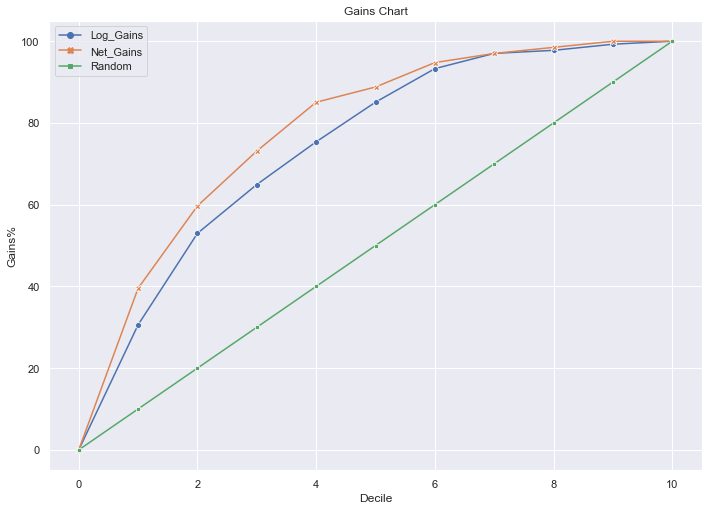

In [53]:
# Comparing Gains Curves
sns.set(rc={'figure.figsize':(11.7,8.27)})
df = pd.DataFrame()
df['Decile'] = net_DA['Decile']
df['Log_Gains'] = claims_DA['Gain'].copy()
df['Net_Gains'] = net_DA['Gain'].copy()
df['Random'] = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90 , 100]
sns.set_theme()
ax = sns.lineplot(data=df.iloc[:, 1:4],
markers=True, dashes=False)
ax.set_title('Gains Chart')
ax.set_xlabel('Decile')
ax.set_ylabel('Gains%')


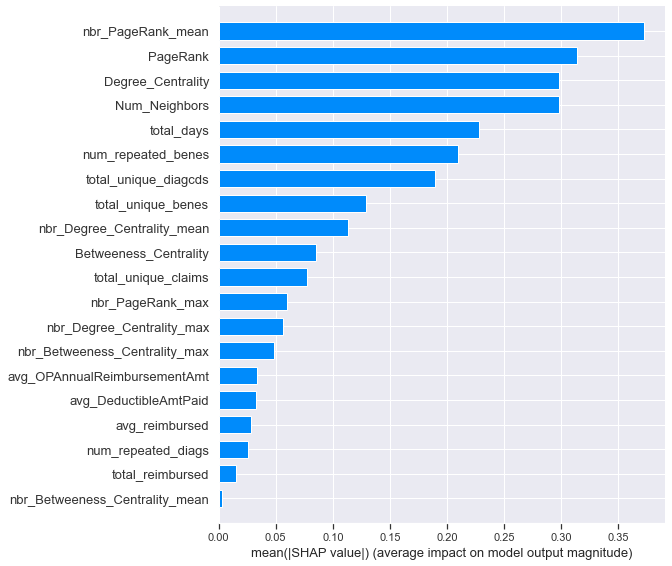

In [60]:
# Variable Importance
shap.summary_plot(shap_values, x_test.to_numpy(), list(X_test.columns), plot_type='bar')


In [62]:
# Creating Bipartite Graph for Method 2
B1 = nx.from_pandas_edgelist(edge_list, source = 'AttendingPhysician', target = 'Provider',edge_attr=True, create_using=nx.DiGraph())

print('Number of nodes : {}'.format(len(B1.nodes())))
print('Number of edges : {}'.format(len(B1.edges())))

Number of nodes : 79120
Number of edges : 79273


In [63]:
# PageRank
pr = pagerank(B1, weight  = 'weight')

In [65]:
# PageRank
pr_df = pd.DataFrame()
pr_df['Provider'] = list(pr.keys())
pr_df['PageRank'] = list(pr.values())

pr_df = pr_df[pr_df['Provider'].isin(list(edge_list['Provider'].unique()))]
pr_df = pr_df.merge(target, on = 'Provider', how = 'inner')
pr_df = pr_df.rename(columns={'PotentialFraud':'Fraud_Yes'}) 

In [68]:
pr_df = pr_df.sort_values(by = 'PageRank', ascending=False)
pr_df['Fraud_Yes'] = pr_df['Fraud_Yes'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# Decile Analysis for PageRank
pr_df['Decile'] = pd.qcut(pr_df['PageRank'], 10, labels=[i for i in range (10, 0, -1)])

res = pd.crosstab(pr_df['Decile'], pr_df['Fraud_Yes'])[1].reset_index().rename(columns = {1: 'Number of Fraudsters'})
lg = pr_df['Decile'].value_counts(sort = False).reset_index().rename(columns = {'Decile': 'Number of Providers', 'index': 'Decile'})
lg = pd.merge(lg, res, on = 'Decile').sort_values(by = 'Decile', ascending = False).reset_index(drop = True)     
lg['Cumulative Number of Fraudsters'] = lg['Number of Fraudsters'].cumsum()
lg['% of Fraudsters'] = np.round(((lg['Number of Fraudsters']/lg['Number of Fraudsters'].sum())*100),2)
lg['Gain'] = lg['% of Fraudsters'].cumsum()
lg['Decile'] = lg['Decile'].astype('int')
lg.loc[-1] = [0,0,0,0,0,0]  # adding a row
lg.index = lg.index + 1  # shifting index
lg = lg.sort_index()
lg

Text(0, 0.5, 'Gains%')

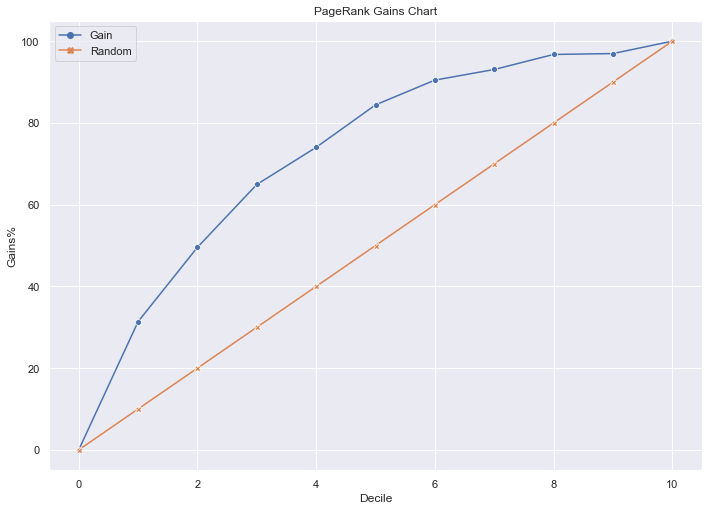

In [79]:
# Visualization of Gains Curve 
sns.set(rc={'figure.figsize':(11.7,8.27)})
df = pd.DataFrame()
df['Decile'] = lg['Decile']
df['Gain'] = lg['Gain'].copy()
df['Random'] = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90 , 100]
sns.set_theme()
ax = sns.lineplot(data=df.iloc[:, 1:3],
markers=True, dashes=False)
ax.set_title('PageRank Gains Chart')
ax.set_xlabel('Decile')
ax.set_ylabel('Gains%')

In [83]:
# Getting z-scores
pr_df['z-score'] = (pr_df['PageRank'] - pr_df['PageRank'].mean())/pr_df['PageRank'].std(ddof=0)
pr_df

,Provider,PageRank,Fraud_Yes,Decile,z-score
763,PRV52019,0.003020,1,1,19.296876
3127,PRV55215,0.002901,1,1,18.512193
3350,PRV55510,0.002356,0,1,14.920461
4557,PRV57173,0.001670,1,1,10.399298
3914,PRV56268,0.001608,1,1,9.993961
...,...,...,...,...,...
3459,PRV55649,0.000007,0,10,-0.558328
3558,PRV55787,0.000007,0,10,-0.558421
4989,PRV57738,0.000007,0,10,-0.558702
947,PRV52256,0.000007,0,10,-0.558715
